# Численное решение двумерного уравнения теплопроводности

<span style="font-style:normal; font-size:14pt;">
$$
\begin{cases}
u_{t} = a^{2} (u_{xx} + u_{yy}) + q(x,y,t), \ \ \ \ 0 < x < l_1, \ \ \ \  0 < y < l_2 \ \ \ 0 < t,  \\
u(x,y,0) = \varphi,(x,y),                                                      \\
\alpha \frac{\partial u}{\partial n} + \left.\beta u\right|_S = \left.\gamma\right|_S,        \\ 
\end{cases}
$$

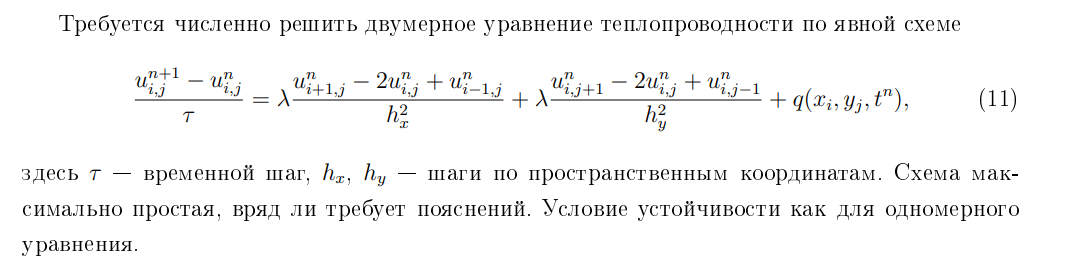

In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets   import Slider, Button
from matplotlib           import cm
import numpy as np

# from mpl_toolkits.mplot3d import axes3d

In [2]:
# условие устойчивости Куранта
def Kurant_condition(h_x, h_y, a, c=0.9):
    
    t_x = round(c * h_x**2 / 2 / a**2 / 2, 4)
    t_y = round(c * h_y**2 / 2 / a**2/ 2, 4)
    
    if t_x < t_y:
        t = t_x
    else:
        t = t_y
    
    return t

In [3]:
# Численное решение

class Apprx_Solution:
    def __init__(self, 
                 left_x, right_x, h_x, left_y, right_y, h_y, t0, T,
                 a, q, phi,
                 alpha_x, beta_x, gamma_x, 
                 alpha_y, beta_y, gamma_y):
        
        t = Kurant_condition(h_x, h_y, a)
        
        self.left_x  = left_x
        self.right_x = right_x
        self.h_x     = h_x
        
        self.left_y  = left_y
        self.right_y = right_y
        self.h_y     = h_y
        
        self.t0 = t0
        self.T  = T
        self.t  = t
        
        self.a   = a
        self.q   = q
        self.phi = phi
        
        self.alpha_x = alpha_x
        self.beta_x  = beta_x
        self.gamma_x = gamma_x
        
        self.alpha_y = alpha_y
        self.beta_y  = beta_y
        self.gamma_y = gamma_y
        
        return

    
    def calc(self, t_i):
        
        left_x  = self.left_x
        right_x = self.right_x
        h_x     = self.h_x
        
        left_y  = self.left_y
        right_y = self.right_y
        h_y     = self.h_y
        
        t0 = self.t0
        T  = self.T
        t  = self.t
        
        a   = self.a
        q   = self.q
        phi = self.phi
        
        alpha_x = self.alpha_x
        beta_x  = self.beta_x
        gamma_x = self.gamma_x
        
        alpha_y = self.alpha_y
        beta_y  = self.beta_y
        gamma_y = self.gamma_y
        
        
        if t_i > T or t_i < t0:
            raise ValueError(f'The time must belong to the interval [{t0},{T}]')
        
        
        
        u_plot = 0

        # Задание пространственной сетки
        x_plot = np.linspace(left_x, right_x, round((right_x - left_x) / h_x) + 1)       # координатная сетка x
        y_plot = np.linspace(left_y, right_y, round((right_y - left_y) / h_y) + 1)       # координатная сетка y
        t_plot = np.linspace(t0,     t_i,     round((t_i - t0) / t) + 1)                 # временная сетка (слои)
     
        c_x = a**2 * t / h_x**2
        c_y = a**2 * t / h_y**2
    
    
    
        # нижний слой
        t_0_layer = []
        
        for y in y_plot:
            y_i_layer = [phi(x, y) for x in x_plot]
            t_0_layer.append(y_i_layer)
        
        
        # следующие слои
        t_prev_layer = t_0_layer
            
        for t_i in t_plot[1:]:
            t_i_layer = []
            
            
            for j in range(1, len(y_plot) - 1):
                y_i_layer = []
            
                for i in range(1, len(x_plot) - 1):
                    u_ij_k = (c_x * (t_prev_layer[j][i + 1] - 2 * t_prev_layer[j][i] + t_prev_layer[j][i - 1]) + 
                              c_y * (t_prev_layer[j + 1][i] - 2 * t_prev_layer[j][i] + t_prev_layer[j - 1][i]) + 
                              t_prev_layer[j][i] + q(x_plot[i], y_plot[j], t_i))
                    
                    y_i_layer.append(u_ij_k)
                
                u_0j_k = ((alpha_x(y_plot[j], t_i)[0] * y_i_layer[0] + gamma_x(y_plot[j], t_i)[0] * h_x) / 
                          (alpha_x(y_plot[j], t_i)[0]                + beta_x(y_plot[j], t_i)[0]  * h_x))
                u_Mj_k = ((gamma_x(y_plot[j], t_i)[-1] * h_x + alpha_x(y_plot[j], t_i)[-1] * y_i_layer[-1]) / 
                          (alpha_x(y_plot[j], t_i)[-1]       + beta_x(y_plot[j], t_i)[-1]  * h_x))
                
                y_i_layer.insert(0, u_0j_k)
                y_i_layer.append(u_Mj_k)
                
                t_i_layer.append(y_i_layer)         
        
        
        
            y_0_layer = []
            y_N_layer = []
            
            for i in range(0, len(x_plot)):
                
                    u_i1_k   = t_i_layer[0][i]
                    u_iN_1_k = t_i_layer[-1][i]
                    
                    u_i0_k = ((gamma_y(x_plot[i], t_i)[0] * h_y + alpha_y(x_plot[i], t_i)[0] * u_i1_k) / 
                             (beta_y(x_plot[i], t_i)[0]   * h_y + alpha_y(x_plot[i], t_i)[0]))
                    u_iN_k = ((gamma_y(x_plot[i], t_i)[-1] * h_y + alpha_y(x_plot[i], t_i)[-1] * u_iN_1_k) / 
                              (alpha_y(x_plot[i], t_i)[-1]       + beta_y(x_plot[i], t_i)[-1]  * h_y))
                    
                    y_0_layer.append(u_i0_k)
                    y_N_layer.append(u_iN_k)
                    
            t_i_layer.insert(0, y_0_layer)
            t_i_layer.append(y_N_layer)
            
            t_prev_layer = t_i_layer
        
        
        
        u_plot = t_prev_layer
        
        return x_plot, y_plot, u_plot
    
    
    def get_t_step(self):
        return self.t

In [4]:
def graph(t_i, X, Y, Z):
    
    fig  = plt.figure(figsize=(6, 6))
    ax   = fig.add_subplot(111, projection='3d')
    ax.text2D(0.05, 0.95, "T={0:.4f}".format(t_i), transform=ax.transAxes, 
              fontsize=10, bbox=dict(facecolor='orange', alpha=0.3))


    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('x', fontsize=8)        
    ax.set_ylabel('y', fontsize=8)
    ax.set_zlabel('u', fontsize=8)
    
    ax.tick_params(labelsize=6)

    plt.savefig(f"./Graphs/Lab11/T={t_i:.4f}.jpg")
#     plt.show()

## Постановка задачи

In [5]:
# Неоднородность
def q(x, y, t):
    return 0

# Начальное условие
def phi(x, y):
    a  = 2.5
    b  = 1
    x0 = 5
    y0 = 5
    
    pos = ((x - x0) / a)**2 + ((y - y0) / b)**2
    
    if pos < 1:
        return 1
    else:
        return 0

In [6]:
# Граничные условия

# ГУ для оси x (левый и правый конец)

def alpha_x(y, t):
    alpha_x1 = 0
    alpha_x2 = 0
    return [alpha_x1, alpha_x2]

def beta_x(y, t):
    beta_x1 = 1
    beta_x2 = 1
    return [beta_x1, beta_x2]

def gamma_x(y, t):
    gamma_x1 = 0
    gamma_x2 = 0
    return [gamma_x1, gamma_x2]


# ГУ для оси y (левый и правый конец)

def alpha_y(x, t):
    alpha_y1 = 0
    alpha_y2 = 0
    return [alpha_y1, alpha_y2]

def beta_y(x, t):
    beta_y1 = 1
    beta_y2 = 1
    return [beta_y1, beta_y2]

def gamma_y(x, t):
    gamma_y1 = 0
    gamma_y2 = 0
    return [gamma_y1, gamma_y2]

In [7]:
# Область значений и шаг по x
left_x  = 0
right_x = 10
h_x     = 0.05 

# Область значений и шаг по y
left_y  = 0
right_y = 10
h_y     = 0.05

# Область значений и шаг по t
t0 = 0
T  = 10
# t  =  0.05       # Вычисляется из условия Куранта

# Параметры задачи                             
a = np.sqrt(0.25)

## Численное решение

<span style="font-style:normal; font-size:12pt;">
    <p>Будем выводить численное решение в конкретный момент времени </p>

In [8]:
apprx_solution = Apprx_Solution(left_x, right_x, h_x, left_y, right_y, h_y, t0, T,
                                a, q, phi,
                                alpha_x, beta_x, gamma_x, 
                                alpha_y, beta_y, gamma_y)

In [9]:
t = apprx_solution.get_t_step()
t

0.0023

In [10]:
# t_i = input("Введите момент времени: ")

In [11]:
# Решение в заданные моменты времени
t_plot = [0, t]

for i in range(12):
    t_i = t_plot[-1] * 2
    t_plot.append(t_i)
    
t_plot

[0,
 0.0023,
 0.0046,
 0.0092,
 0.0184,
 0.0368,
 0.0736,
 0.1472,
 0.2944,
 0.5888,
 1.1776,
 2.3552,
 4.7104,
 9.4208]

In [12]:
len(t_plot)

14

In [13]:
# for index in range(0, len(t_plot), 2):
#     t_i = t_plot[index]
#     x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

#     X, Y = np.meshgrid(x_plot, y_plot)
#     Z    = np.asarray(u_plot_t_i)

#     graph(t_i, X, Y, Z)
    
# if len(t_plot) % 2 == 0:
#     t_i = t_plot[-1]
#     x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

#     X, Y = np.meshgrid(x_plot, y_plot)
#     Z    = np.asarray(u_plot_t_i)

#     graph(t_i, X, Y, Z)

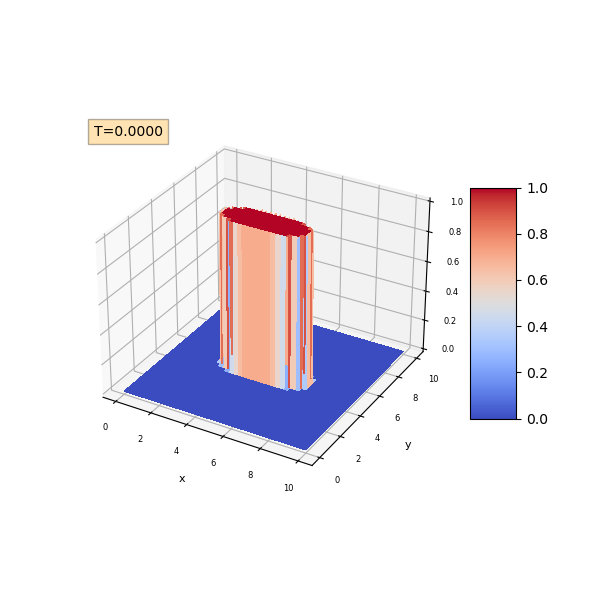

In [15]:
t_i = t_plot[0]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

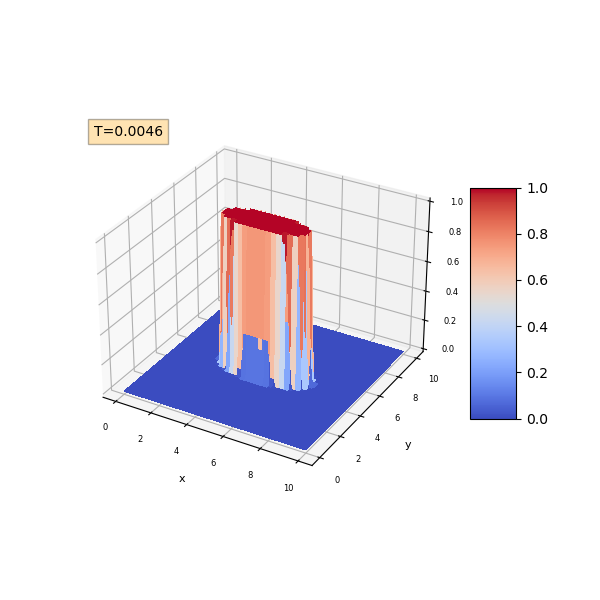

In [16]:
t_i = t_plot[2]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

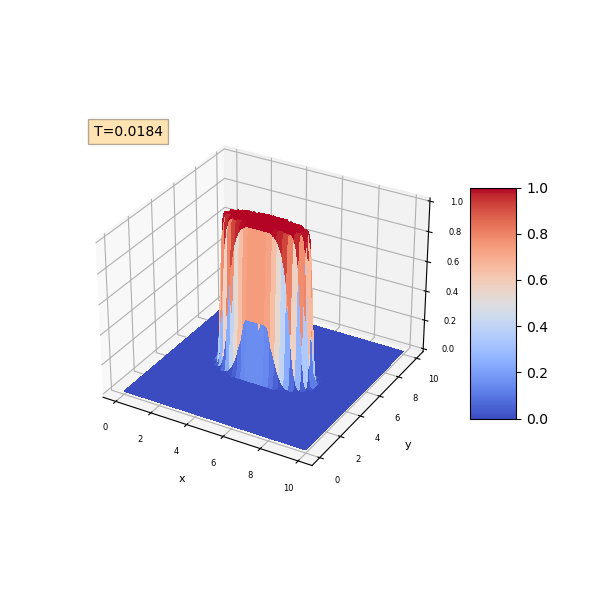

In [17]:
t_i = t_plot[4]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

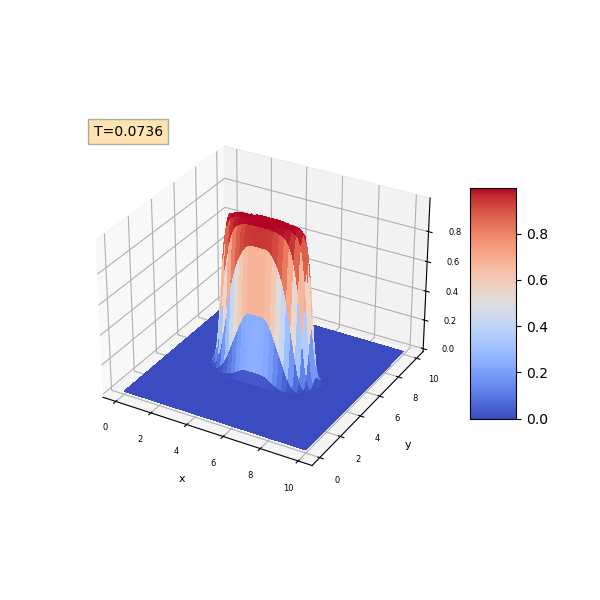

In [18]:
t_i = t_plot[6]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

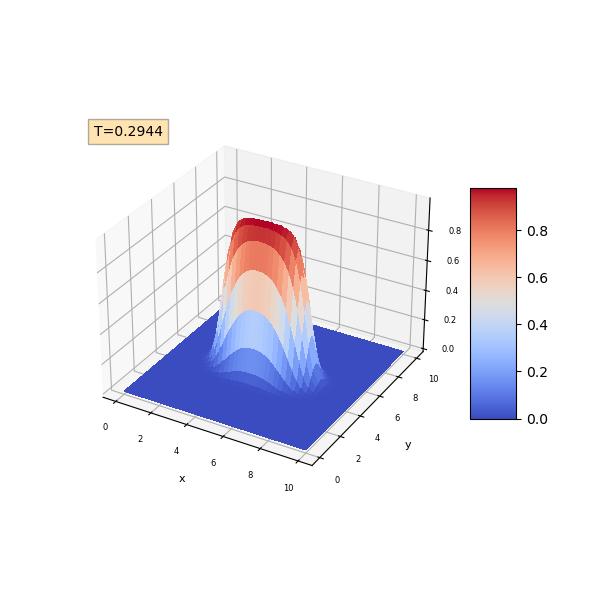

In [19]:
t_i = t_plot[8]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

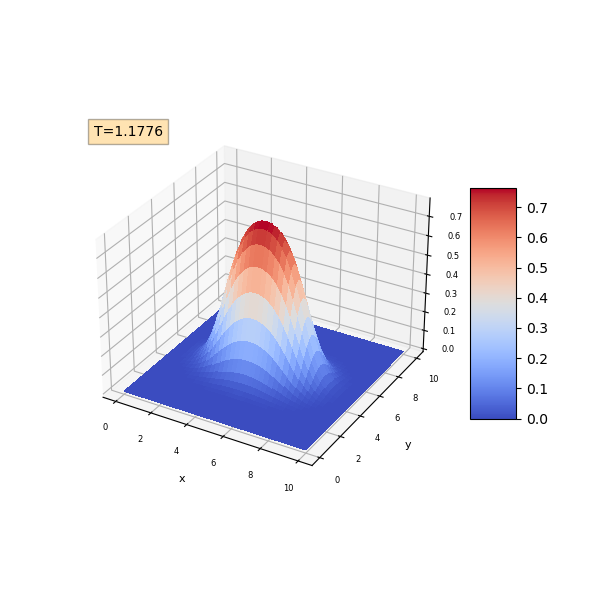

In [20]:
t_i = t_plot[10]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

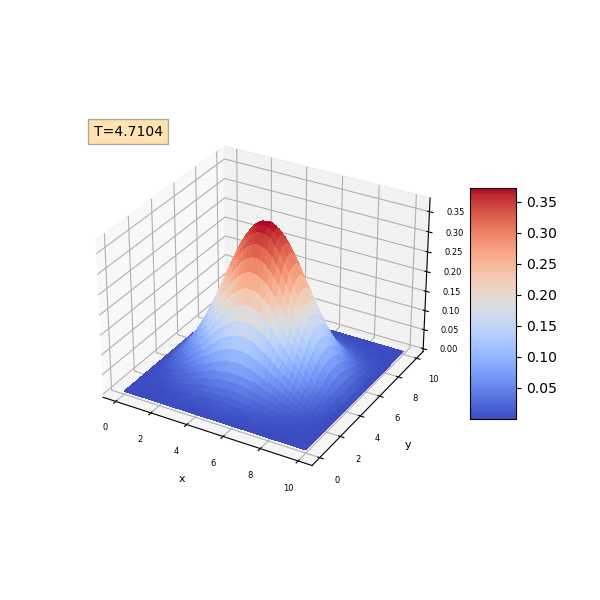

In [21]:
t_i = t_plot[12]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)

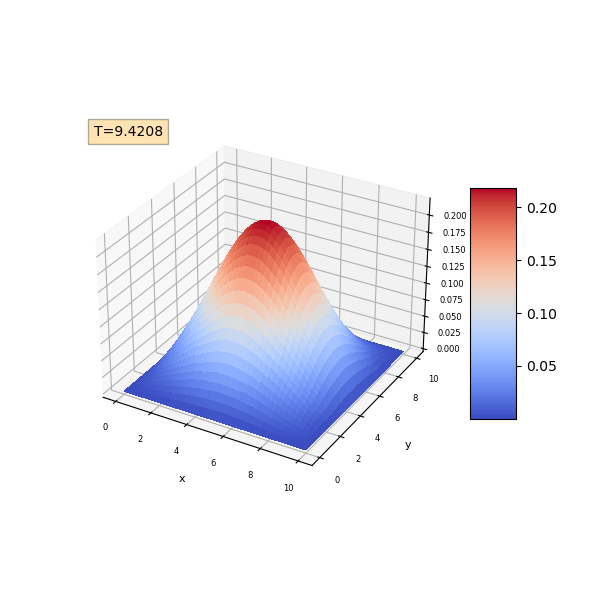

In [23]:
t_i = t_plot[-1]
x_plot, y_plot, u_plot_t_i = apprx_solution.calc(t_i)

X, Y = np.meshgrid(x_plot, y_plot)
Z    = np.asarray(u_plot_t_i)
     
graph(t_i, X, Y, Z)